In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ----- json, dataframe ...etc ------#
import re
import json
import pandas as pd
import numpy as np
import datetime
import time
import requests
import seaborn as sns

# ------ image , animation ----------- #

import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter
from matplotlib.widgets import Slider, Button
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import OffsetImage
from io import BytesIO
from PIL import Image, ImageDraw, ImageOps
from matplotlib.offsetbox import OffsetImage
from IPython.display import HTML


import urllib.request

from tqdm import tqdm # 작업 프로세스

for _ in tqdm(range(10), desc='tqdm test'):
    time.sleep(0.1)

from time import sleep



tqdm test: 100%|██████████| 10/10 [00:01<00:00,  9.82it/s]


# 소환사의 puuid, matchid, matchdata

In [ ]:
api_key = 'RGAPI..
summoner_name = '아이언조련사'

sohwan = "https://kr.api.riotgames.com/lol/summoner/v4/summoners/by-name/{}?api_key={}"
url = sohwan.format(summoner_name, api_key)
response = requests.get(url)
puuid = response.json()['puuid']


In [ ]:
start=0
count=1

matchid_url = "https://asia.api.riotgames.com/lol/match/v5/matches/by-puuid/{}/ids?type=ranked&start={}&count={}&api_key={}"
url = matchid_url.format(puuid, start, count, api_key)
response = requests.get(url)
match_ids = response.json()

match_id = match_ids[0]
match_id

'KR_6489714964'

In [ ]:
match_id = 'KR_6489714964'

time_url = 'https://asia.api.riotgames.com/lol/match/v5/matches/{}/timeline?api_key={}'
url = time_url.format(match_id, api_key)
response = requests.get(url)
match_data = response.json()
match_data

In [ ]:
v5_url = 'https://asia.api.riotgames.com/lol/match/v5/matches/{}?api_key={}'  # matchid , api_key`
url = v5_url.format(match_id ,api_key)
response = requests.get(url)
match_data_v5 = response.json()

df = pd.DataFrame(match_data_v5)
# df = pd.DataFrame(df['info']['participants'])

df

In [ ]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
match_data_v5

In [ ]:
id_df = pd.DataFrame(match_data['info']['participants']) # 참가자의 participantid 와 puuid
participant_ids = id_df['participantId'].tolist() # partcipant_id 를 list 형태로 바꿔줍니다. 왜냐면 각 participant_id 별로 이동경로 데이터들을 한 데이터프레임에 합쳐주기 위해서 입니다.
                                                  # 그냥 json 형태에서 해도 되지만.. 보기 힘들어서 데이터프레임으로 바꾸고 작업

frames_df = pd.DataFrame(match_data['info']['frames']) # 이동경로(moving)은 match_data_log 의 info 컬럼 frames 행안에 있는것을 확인
frames_list = pd.DataFrame(frames_df['participantFrames'])['participantFrames'].tolist() # 다시 list형태로 변경

In [ ]:
frames_list

In [ ]:
def get_match_data_log(summoner_name, api_key, start=0, count=1):
    # Get summoner puuid
    sohwan = "https://kr.api.riotgames.com/lol/summoner/v4/summoners/by-name/{}?api_key={}"
    url = sohwan.format(summoner_name, api_key)
    response = requests.get(url)
    puuid = response.json()['puuid']

    # Get match ids
    # match_ids = ['KR_6442163110']

    # matchid_url = "https://asia.api.riotgames.com/lol/match/v5/matches/by-puuid/{}/ids?type=ranked&start={}&count={}&api_key={}"
    # url = matchid_url.format(puuid, start, count, api_key)
    # response = requests.get(url)
    # match_ids = response.json()

    # Get match data for each match id
    match_ids = ['KR_6496455532']
    match_data_log = []
    time_url = 'https://asia.api.riotgames.com/lol/match/v5/matches/{}/timeline?api_key={}'
    for i, match_id in enumerate(tqdm(match_ids)):
        url = time_url.format(match_id, api_key)
        response = requests.get(url)
        match_data_js = response.json()
        match_data_log.append(pd.DataFrame(response.json()))

        # Pause for 1 second every 20 requests #
        if (i+1) % 20 == 0:
            time.sleep(1)

    return  puuid, match_ids, match_data_js, match_data_log

summoner_name = input("소환사의 닉네임을 적어주세요.: ")

puuid, match_ids,match_data_js, match_data_log = get_match_data_log(summoner_name, api_key)
first_match_data_log = match_data_log[0]
first_match_id = match_ids[0]

소환사의 닉네임을 적어주세요.: 즐겜하고싶은유저


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


In [ ]:
match_ids

['KR_6489714964']

In [ ]:
# match id 가여러개
match_data = []
url_v5 = 'https://asia.api.riotgames.com/lol/match/v5/matches/{}?api_key={}'  # matchid , api_key

for match_id in match_ids:
    url_now = url_v5.format(match_id, api_key)
    time = requests.get(url_now).text
    df = json.loads(time)
    match_data.append(pd.DataFrame(df))

match_df = pd.concat(match_data)
df = pd.DataFrame(match_df['info']['participants'])

participants_list = []

for i in range(len(df)):
    participant_df = pd.DataFrame(df.iloc[i]['info'])
    participant_df['match_id'] = match_df['metadata']['matchId'][i]
    participants_list.append(participant_df)

match_data_10 = pd.concat(participants_list)

In [ ]:
summoner_match_30= match_data_10[match_data_10['puuid']== puuid ]
selected_columns = ['match_id','timePlayed','teamId','summonerName','participantId','puuid','teamPosition', 'challenges',
    'championName','lane','kills','deaths','assists','totalMinionsKilled','neutralMinionsKilled','goldEarned','goldSpent','champExperience','item0','item1','item2',
    'item3','item4','item5','item6','totalDamageDealt','totalDamageDealtToChampions','totalDamageTaken','damageDealtToTurrets','damageDealtToBuildings',
    'totalTimeSpentDead','visionScore','win','timePlayed']

match_data_10[selected_columns][match_data_10['puuid'] == puuid ] # KR_6491021155 도중에 탈주한 match_id

In [ ]:
#  match_v5
def get_match_v5(first_match_id,api_key):

    v5_url = 'https://asia.api.riotgames.com/lol/match/v5/matches/{}?api_key={}'  # matchid , api_key`
    url = v5_url.format(first_match_id,api_key)
    response = requests.get(url)
    match_data_v5 = response.json()

    meta = pd.DataFrame(match_data_v5)
    df = pd.DataFrame(meta['info']['participants'])

    sample = df[['teamId','puuid','summonerName','participantId','teamPosition', 'challenges',
        'championName','lane','kills','deaths','assists','totalMinionsKilled','neutralMinionsKilled','goldEarned','goldSpent','champExperience','item0','item1','item2',
        'item3','item4','item5','item6','totalDamageDealt','totalDamageDealtToChampions','totalDamageTaken','damageDealtToTurrets','damageDealtToBuildings',
        'totalTimeSpentDead','visionScore','win','timePlayed']]

    challenge = pd.DataFrame(sample['challenges'].tolist())

    col = challenge[['soloKills','abilityUses','damageTakenOnTeamPercentage','skillshotsDodged','skillshotsHit','enemyChampionImmobilizations','laneMinionsFirst10Minutes','controlWardsPlaced','visionScoreAdvantageLaneOpponent'
                    , 'visionScorePerMinute','wardTakedowns','effectiveHealAndShielding','dragonTakedowns','baronTakedowns','teamBaronKills']]
    jungle_col = challenge.filter(regex='^jungle|Jungle|kda')

    match_info = pd.concat([sample , col, jungle_col], axis = 1)
    match_info['matchId'] = meta['metadata']['matchId']
    champion_info = match_info[['matchId','participantId','teamId','teamPosition','summonerName','puuid','championName']]

    return  match_info, champion_info

match_info, champion_info = get_match_v5(first_match_id, api_key)


In [ ]:
match_info

In [ ]:
df = pd.DataFrame(df['perks'].tolist())

In [ ]:
style = pd.DataFrame(df['styles'].tolist())

In [ ]:
style

In [ ]:
summoner_participantId = match_info[match_info['puuid'] == puuid]['participantId'].iloc[0] # 입력된 소환사의 teampositino 정의


In [ ]:
id_df = pd.DataFrame(first_match_data_log['info']['participants']) # 참가자의 participantid 와 puuid
participant_ids = id_df['participantId'].tolist() # partcipant_id 를 list 형태로 바꿔줍니다. 왜냐면 각 participant_id 별로 이동경로 데이터들을 한 데이터프레임에 합쳐주기 위해서 입니다.
                                                  # 그냥 json 형태에서 해도 되지만.. 보기 힘들어서 데이터프레임으로 바꾸고 작업

frames_df = pd.DataFrame(first_match_data_log['info']['frames']) # 이동경로(moving)은 match_data_log 의 info 컬럼 frames 행안에 있는것을 확인
frames_list = pd.DataFrame(frames_df['participantFrames'])['participantFrames'].tolist() # 다시 list형태로 변경

moving_data = [ [] for _ in range(len(participant_ids)) ]
for frame in frames_list:
      # Loop through each participant id
      for i, participant_id in enumerate(participant_ids):
          # Check if the participant id is in the frame data
          if str(participant_id) in frame:
              # Append the position data to the moving data for the current participant
              moving_data[i].append(frame[str(participant_id)])
moving_dfs = [pd.DataFrame(md) for md in moving_data]
moving = pd.concat(moving_dfs)

# 추출한 timestamp열을 frames_timestamp 변수에 저장
frames_timestamp = frames_df['timestamp']
# timestamp 열을 추가하여 moving 데이터프레임의 행과 열 개수를 확인
moving['timestamp'] = frames_timestamp
summoner_moving = moving[moving['participantId'] == summoner_participantId ]


In [ ]:
df = moving[moving['participantId'] == summoner_participantId]

In [ ]:
frame_df = pd.DataFrame(first_match_data_log['info']['frames'])
events_df = pd.DataFrame(frame_df['events'])
frame_df

In [ ]:
frame_df = pd.DataFrame(first_match_data_log['info']['frames'])
events_df = pd.DataFrame(frame_df['events'])
summoner_participantId = match_info[match_info['puuid'] == puuid]['participantId'].iloc[0] # 입력된 소환사의 teampositino 정의

events = events_df['events'].tolist()

events_participant = []

for event in events:
    for event_dict in event:
        if event_dict.get('participantId') == summoner_participantId: # 특정유저 events
            events_participant.append(event_dict)

events_summoner = pd.DataFrame(events_participant)

In [ ]:
events_summoner

In [ ]:
frame_df = pd.DataFrame(first_match_data_log['info']['frames'])
events_df = pd.DataFrame(frame_df['events'])
events = events_df['events'].tolist()

events_all_participant_ids = []

for event in events:
    for event_dict in event:
        events_all_participant_ids.append(event_dict)

all_events = pd.DataFrame(events_all_participant_ids)


position_ok = all_events[all_events['position'].notnull()] # 좌표가 있는 데이터만 (kill, monster kill)
summoner_events = all_events[(all_events['participantId'] == summoner_participantId) | (all_events['victimId']== summoner_participantId) | (all_events['killerId']== summoner_participantId)]
summoner_events = summoner_events[['timestamp','type','itemId','participantId','killerId','position','victimId','assistingParticipantIds','victimDamageDealt','victimDamageReceived']] # 핵심 변수만만


In [ ]:
death_log = position_ok[position_ok['victimId'] == summoner_participantId][['timestamp','type','victimId','position']]
death_log

,timestamp,type,victimId,position
143,301689,CHAMPION_KILL,6.0,"{'x': 1738, 'y': 12404}"
199,426295,CHAMPION_KILL,6.0,"{'x': 2898, 'y': 13292}"


# 이벤트로그

In [ ]:
# main_events = all_events[['timestamp','type','itemId','participantId','position','killerId','assistingParticipantIds','victimId','monsterType',	'monsterSubType','buildingType',	'towerType']]
building_events = all_events[(all_events['type'] == 'ELITE_MONSTER_KILL') | (all_events['type'] == 'BUILDING_KILL')] # or = | / and = &
building_events= building_events[['timestamp','type','position','killerId','assistingParticipantIds','monsterType',	'monsterSubType','laneType','buildingType','towerType']]

In [ ]:
position_ok

In [ ]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
df_k = all_events[(all_events['type'] == 'CHAMPION_KILL')]
df = df_k[['timestamp','participantId','killerId','victimId','assistingParticipantIds','position','victimDamageDealt','victimDamageReceived']]


In [ ]:
df

In [ ]:
kill = df[['killerId','position','timestamp']]
# kill = df[['killerId','position','timestamp']]
# kill['kill'] = 1
# kill.rename(columns={'killerId':'participantId'}, inplace=True)
# kill = kill.sort_values(by='participantId' ,ascending=True)
# kill['participantId'] = kill['participantId'].astype(int)


df = position_ok[position_ok['victimId'] == summoner_participantId]
death = df[['victimId','position','timestamp']]
death['death'] = 1
death.rename(columns={'victimId':'participantId'}, inplace=True)
death = death.sort_values(by='participantId',ascending=True)
death['participantId'] = death['participantId'].astype(int)

In [ ]:
death

,participantId,position,timestamp,death
143,6,"{'x': 1738, 'y': 12404}",301689,1
199,6,"{'x': 2898, 'y': 13292}",426295,1


In [ ]:
moving = moving[['participantId','position','timestamp']]
moving_df = pd.concat([death, moving], axis=0, sort=False)
moving_df = moving_df.sort_values(by=['timestamp'], ignore_index=True, ascending=True)

In [ ]:
champion_info

,matchId,participantId,teamId,teamPosition,summonerName,puuid,championName
0,KR_6496455532,1,100,TOP,태종태셰비욘세,sRSxIpJon8_JTm1saLA3Q_Ruzl7BCzfLX0TAHNgiYCgiRv...,Kennen
1,KR_6496455532,2,100,JUNGLE,살상연희살상연화,BlaZiFWG7NV8Sz-5DeCZaNKaXY6DuHKW3x2bVB2_DTAZbS...,FiddleSticks
2,KR_6496455532,3,100,MIDDLE,오산고급식판도둑,QQ4dBC6YzRHYIl9xQfthXvn_WUoqOh4zjLFu46Q4MEn8kZ...,Yone
3,KR_6496455532,4,100,BOTTOM,잭파잉,uE5NLGThsY4-IlqXmxnX1wLqB-gD0HIRo4L2NCu_pCYgJ5...,Ezreal
4,KR_6496455532,5,100,UTILITY,삼성개쉽손해보험,wZBF2V8Vfa07KrGV6nf17FrOR4b1LEhU8xYWmVajEPHMY_...,Soraka
5,KR_6496455532,6,200,TOP,즐겜하고싶은유저,ylKK4tgqGkahMfm4jDLzV1S07foE-BVb25QbnoaNhH99nS...,Graves
6,KR_6496455532,7,200,JUNGLE,세무유나이티드,2UciTB_9lDtWJmjT8WmILgCXkedk0KP4-0DcQNV-i_2K5s...,Amumu
7,KR_6496455532,8,200,MIDDLE,블라디미르노밴,VD0aQs3pJWCkqmbJ_dpPtlXQOXjQ1CnvjZ5NrkTVf5GvUR...,Vladimir
8,KR_6496455532,9,200,BOTTOM,OnlyGoAD,JR8F6yFurG9blzJ_xF-55A3ylgAtlErkkJ9_OxBSeFqgq8...,Kaisa
9,KR_6496455532,10,200,UTILITY,300골드 수집가,pjgQRfr0vNpahMd1wdK9zD7eHQQC5rF6MpfzzjAhyeo5JF...,Nautilus


In [ ]:
logs_dk = pd.concat([logs_df,kill], axis=0, sort=False)
logs_dk = logs_dk.sort_values(by=['timestamp'], ignore_index=True, ascending=True)

# kill 위치 포함함

In [ ]:
logs_df

In [ ]:
import pandas as pd

def get_dict(row):
    return {'participantId': row['participantId'],
            'position': row['position'],
            'death': row['death']}


# 'timestamp' 컬럼을 datetime 형식으로 변환하여 새로운 컬럼으로 추가
logs_df['datetime'] = pd.to_datetime(logs_df['timestamp'], unit='ms')

# 시간대별로 묶은 데이터프레임 생성
logs_df_grouped = logs_df.groupby(pd.Grouper(key='datetime', freq='1min'))

# 시간대별로 dictionary를 만들어서 list에 추가
result = []
for timestamp, group in logs_df_grouped:
    temp_dict = {}
    for _, row in group.iterrows():
        temp_dict[row['participantId']] = get_dict(row)
    result.append(temp_dict)


In [ ]:
df = building_events
monster = df[df['type']== 'ELITE_MONSTER_KILL'][['killerId','position','timestamp','monsterType','monsterSubType']]
monster.rename(columns={'killerId':'participantId'}, inplace=True)
monster['monsterkill'] = 1

# dragon 좌표 = {'x': 9866, 'y': 4414} / 바론,전령 좌표 = {'x': 4932, 'y': 10020}

In [ ]:
building = df[df['type']=='BUILDING_KILL'][['killerId','position','timestamp','laneType'	,'buildingType','towerType']]
building.rename(columns ={'killerId':'participantId'}, inplace=True)
building['buildingkill']= 1

In [ ]:
df = pd.concat([monster, building], axis=0, sort= False)
logs_3 = pd.concat([logs_dk,df], axis=0, sort=False)
logs_3 = logs_3[['participantId','position','timestamp','death','kill','monsterkill','buildingkill','monsterType','monsterSubType','buildingType','towerType','laneType']]
logs_all = logs_3.sort_values(by=['timestamp'], ignore_index=True, ascending=True)

# position 이 남는 모든 logs  [1분기준좌표, kill/death/monsterkill/buildingkill]



In [ ]:
match_data_js

# MATCH_V5
해당 matchid 의 자세한 matchdata , kda,cs,item deal, deattime, teamposition, ...etc

In [ ]:
logs_df = pd.concat([monster, logs_df], axis=0, ignore_index=True, sort=False)
logs_df = logs_df.sort_values(by=['timestamp'], ignore_index=True, ascending=True)
logs_df

In [ ]:
moving

In [ ]:
logs_df.fillna(value=0, inplace=True)
logs_df

# 이동경로 미니맵으로 표시하기

In [ ]:
import requests
from io import BytesIO
from PIL import Image, ImageDraw, ImageOps,ImageEnhance
from matplotlib.offsetbox import OffsetImage
from skimage.color import rgb2gray


In [ ]:
logs_df

In [ ]:
champion_images = {}
for idx, champ in champion_info.iterrows():
    champion_name = champ['championName']
    champion_url = f"https://ddragon.leagueoflegends.com/cdn/13.9.1/img/champion/{champion_name}.png"
    response = requests.get(champion_url)
    img = Image.open(BytesIO(response.content))
    champion_images[champion_name] = img

# 이미지 원형으로 자르기 및 크기 조절
for champion_name, img in champion_images.items():
    # 원형으로 자르기
    mask = Image.new("L", img.size, 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((0, 0) + img.size, fill=255)
    img.putalpha(mask)
    # 크기 조절
    img = img.resize((100, 100))

UnidentifiedImageError: ignored

In [ ]:
champion_info

,matchId,participantId,teamId,teamPosition,summonerName,puuid,championName
0,KR_6466233467,1,100,TOP,마닝킹,deP83YuHsLSWgTUVPHo7egBRCdT9r4AexuWu-WyyDF6OMD...,Mordekaiser
1,KR_6466233467,2,100,JUNGLE,냐아코,h0TZ1lCN2PoTa2BBwi3qf5q2LBZ_jy6I8tAl2LacKbAbQb...,Warwick
2,KR_6466233467,3,100,MIDDLE,졸려려려,A-KKclXq7kHgHgP-hj8zopV8cMGOfSQYCEB_Vst8G00j_A...,Vex
3,KR_6466233467,4,100,BOTTOM,초콩v,YrXzDjICQJWufwGcBZ_Z9iOcyG9yU9fqd6Q9dpEwt57jQB...,Veigar
4,KR_6466233467,5,100,UTILITY,O0OO0OO0O00,m4TNbdabkUfFjtpndt93Rc12-4IN9CVIw9u-tR6Z7-EFy7...,Nunu
5,KR_6466233467,6,200,TOP,나는 유온,6S9V-_TbtGMDbcj1D7Kx0C5v07YW-e-eqPYgwCBzuyEBz6...,Olaf
6,KR_6466233467,7,200,JUNGLE,응아똥쟁이,4mU2x08V3ydcuhL4qPff2HZiSqbN8DTMXLYdOC1q4mV3VN...,Trundle
7,KR_6466233467,8,200,MIDDLE,꺼져라벌레,hCYUNXGpW0izlR-rDCZW39hlApZG2ihhvx5PQoVFngpBqq...,Yone
8,KR_6466233467,9,200,BOTTOM,핑크색현빈,eyM7Bys3eV4DDYs1FaNm7tD7NmYb9pScANmnHYwCBLJn0D...,Kaisa
9,KR_6466233467,10,200,UTILITY,사랑해이년이,vmT3MQzc95atKaLKwghBWr7YNuUqmw9sivILevRojHdQPQ...,FiddleSticks


In [ ]:
champion_images = {}

for idx, champ in champion_info.iterrows():
    champion_name = champ['championName']
    champion_url = f"https://ddragon.leagueoflegends.com/cdn/13.6.1/img/champion/{champion_name}.png"
    response = requests.get(champion_url)
    img = Image.open(BytesIO(response.content))
    # 이미지 채도 조절
    # enhancer = ImageEnhance.Color(img)
    # img = enhancer.enhance(1)
    champion_images[champion_name] = img

# 이미지 원형으로 자르기 및 크기 조절
for champion_name, img in champion_images.items():
    # 원형으로 자르기
    mask = Image.new("L", img.size, 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((0, 0) + img.size, fill=255)
    img.putalpha(mask)
    # 크기 조절
    img = img.resize((100, 100))
    img.show()



UnidentifiedImageError: ignored

In [ ]:
for participant_id in participant_ids:
    # Filter champion_info to only include rows for the current participant
    participant_champs = champion_info[champion_info['participantId'] == participant_id]
    # Get the name of the champion for the current participant
    champion_name = participant_champs.iloc[0]['championName']


In [ ]:
moving = moving[['participantId','position','timestamp']]
moving

In [ ]:
champion_info

,matchId,participantId,teamId,teamPosition,summonerName,puuid,championName
0,KR_6460764629,1,100,TOP,올시즌웨어,bSMGTkWVyxcl33TfZemeBEjTusZWcosjwsvisdRdYlyANe...,Pantheon
1,KR_6460764629,2,100,JUNGLE,님들보단잘해요,-3et0j6mAgtXHjHdN7ZDmEckMRMlOPydWe2_ZYQ5I1f_zG...,Sylas
2,KR_6460764629,3,100,MIDDLE,힐로불사,x8ze0Pq2oaU2QO0aaYToGvlKUuGKcFcWTQaoZYEopv9rwJ...,Ryze
3,KR_6460764629,4,100,BOTTOM,호균팡,0zv4vLPyhTA8Cmi-IhZapfufm481RajxG5kpwZ0q6e5vYJ...,Ezreal
4,KR_6460764629,5,100,UTILITY,뽀뽄데혀왜넣어요,yyyYQjcvj-dtV_GExhI6Aix-OhmHKV-QRPMGkSbqTiCmVT...,Thresh
5,KR_6460764629,6,200,TOP,아리가또셰셰,UpuGQXAFumuuAPoZIaNJ2wDXir24HigfPyFwSyqFT3eXpT...,Yasuo
6,KR_6460764629,7,200,JUNGLE,섭섭한틀니,dZo96KClxg1v-rflAqu3EgTR1bX7MyHcli9Jo89ljJy7ox...,Kayn
7,KR_6460764629,8,200,MIDDLE,Jotace,bzCmP9DNVMmWVMnA_BQaOuccNFBp4IYri_HoMGEDXN8p3B...,Ziggs
8,KR_6460764629,9,200,BOTTOM,초보사냥꾼2,HVx1IPmOUPTPIcqZt75t_EVqXr9mCdHeofOyjjtRumwTLJ...,Jinx
9,KR_6460764629,10,200,UTILITY,안아죠,cupl9R8OkJkQ7DwyVqME7r2im9F_RzBOfBcBejP6nnN-EA...,Yuumi


In [ ]:
logs_df

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


<IPython.core.display.HTML object>


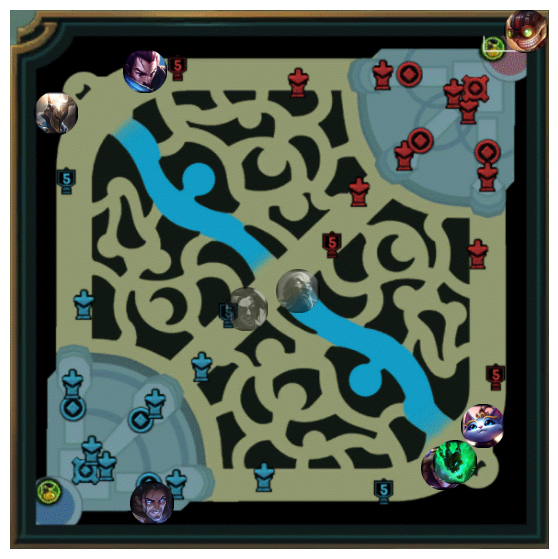

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.widgets import Button
# from matplotlib.animation import FuncAnimation
# from PIL import Image
# from io import BytesIO
# import requests


def create_animation(participant_ids, champion_info, logs_df):
# -------------------------------------------- map , update , animation -------------------------------------------- #
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set_xlim(0, 15000)
    ax.set_ylim(0, 15000)
    plt.axis('off')

    # Add image of map
    map_path = "/content/drive/MyDrive/minimap.png"
    img = Image.open(map_path)
    ax.imshow(img, extent=[0, 15000, 0, 15000])

      # Add image of map
      # map_url = f"https://ddragon.leagueoflegends.com/cdn/11.1.1/img/map/map11.png"
      # response = requests.get(map_url)
      # img = Image.open(BytesIO(response.content))
      # ax.imshow(img, extent=[0, 15000, 0, 15000])


# --------------------------------------------- 챔피언별 이미지 추가 ------------------------------------------------ #
    # 챔피언별 이미지 추가


    # Create image plots for each participant
    images = []
    for participant_id in participant_ids:
        # Filter champion_info to only include rows for the current participant
        participant_champs = champion_info[champion_info['participantId'] == participant_id]
        # Get the name of the champion for the current participant
        champion_name = participant_champs.iloc[0]['championName']
        # Load the corresponding image
        image = champion_images[champion_name]
        # Create a new plot for the image
        # alpha = 1.0 if participant_champs.iloc[0]['puuid'] == puuid else 0.8
        plot = ax.imshow(image)
        images.append(plot)

    def update(frame):
        # Get timestamp for the current frame
        timestamp = logs_df['timestamp'].unique()[frame]
        for i, participant_id in enumerate(participant_ids):
            # Filter logs_df to only include rows for the current participant and timestamp
            participant_df = logs_df[(logs_df['participantId'] == participant_id) & (logs_df['timestamp'] == timestamp)]
            # Get x and y positions for the current participant
            if not participant_df.empty:
                x = participant_df.iloc[0]['position']['x']
                y = participant_df.iloc[0]['position']['y']
                # Update the image plot for the current participant
                if participant_df.iloc[0]['death'] == 1:
                    # Decrease saturation of the image
                    alpha = 0.6
                    image = Image.fromarray(images[i].get_array())
                    enhancer = ImageEnhance.Color(image)
                    image = enhancer.enhance(0)
                    images[i].set_data(np.array(image))
                else:
                    alpha = 1
                    image = champion_images[champion_info[champion_info['participantId'] == participant_id].iloc[0]['championName']]
                    images[i].set_data(image)
                images[i].set_alpha(alpha)
                images[i].set_extent([x - 600, x + 600, y - 600, y + 600])

        return tuple(images)


    # Set up animation

    # num_frames = len(logs_df['timestamp'].unique())
    ani = FuncAnimation(fig, update, frames=20, interval=200, blit=True)

    # Add animation buttons

    return ani
ani = create_animation(participant_ids, champion_info, logs_df)

HTML(ani.to_jshtml())
# print(HTML(ani.to_jshtml()))

In [ ]:
frame_counts = [len(logs_dk[logs_dk['participantId'] == participant_id]) for participant_id in participant_ids]
num_frames = len(logs_dk['timestamp'].unique())
frame_counts

[35, 22, 29, 21, 24, 28, 23, 27, 25, 28]

In [ ]:
logs_dk

,participantId,position,timestamp,death,kill
0,4,"{'x': 458, 'y': 271}",0,NaN,NaN
1,10,"{'x': 14281, 'y': 14199}",0,NaN,NaN
2,2,"{'x': 593, 'y': 464}",0,NaN,NaN
3,7,"{'x': 14539, 'y': 14394}",0,NaN,NaN
4,6,"{'x': 14500, 'y': 14511}",0,NaN,NaN
5,1,"{'x': 554, 'y': 581}",0,NaN,NaN
6,5,"{'x': 335, 'y': 269}",0,NaN,NaN
7,3,"{'x': 557, 'y': 345}",0,NaN,NaN
8,8,"{'x': 14503, 'y': 14275}",0,NaN,NaN
9,9,"{'x': 14404, 'y': 14201}",0,NaN,NaN


In [ ]:
logs_df2 = logs_df.sort_values(by=['participantId', 'timestamp'], ignore_index=True, ascending=True)
logs_df2

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# 이동경로 점수 매기기



In [ ]:
# top_range : (20 ~ 60, 30 ~ 220), (20 ~ 150, 20 ~ 160), (30 ~ 200, 20 ~ 60)
# mid_range : (195 ~ 265, 250 ~ 310), (220 ~ 295, 220 ~ 290), (250 ~ 320, 200 ~ 260), (290 ~ 350, 160 ~ 215), (160 ~ 220, 290 ~ 340)
# bot_range : (310 ~ 460, 435 ~ 485), (400 ~ 490, 385 ~ 480), (440 ~ 490, 310 ~ 455)
# etc_range : (0 ~ 170, 340 ~ 512), (340 ~ 512, 0 ~ 170)

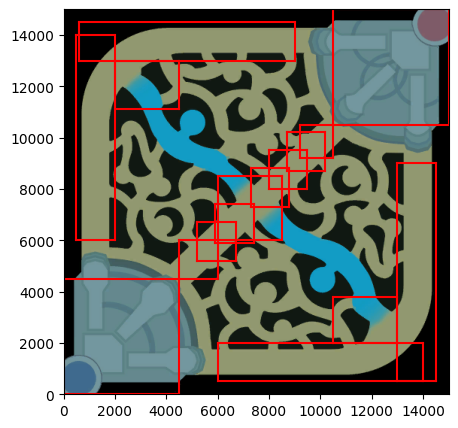

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 이미지 파일 불러오기

# 이미지 플롯 생성
fig, ax = plt.subplots(figsize=(5, 5))

map_url = f"https://ddragon.leagueoflegends.com/cdn/13.6.1/img/map/map11.png"
response = requests.get(map_url)
img = Image.open(BytesIO(response.content))
ax.imshow(img, extent=[0, 15000, 0, 15000])

# Define range
range_list = [
             (500, 2000, 6000, 14000), (600, 9000, 13000, 14500), (2000,4500,11100,13000),
              (6000, 14000, 500, 2000),(13000,14500,500,9000),(10500,13000,2000,3800),
              (4500, 6000, 4500, 6000),(5200,6700,5200,6700),(5900,7400,5900,7400),(6000,8500,6000,8500),(7300,8800,7300,8800),(8000,9500,8000,9500),(8700,10200,8700,10200),(9200,10500,9200,10500),
              (0,4500,0,4500),(10500,15000,10500,15000)
              ]


# Plot each range
for x_start, x_end, y_start, y_end in range_list:
    # Generate all possible x, y combinations within the range
    x, y = np.meshgrid(np.arange(x_start, x_end, 1), np.arange(y_start, y_end, 1))

    # Flatten x and y to 1D arrays
    x_flat = x.flatten()
    y_flat = y.flatten()

    # Filter out coordinates outside of range
    coords_within_range = (x_flat >= x_start) & (x_flat <= x_end) & (y_flat >= y_start) & (y_flat <= y_end)

    # Plot filtered coordinates
    # ax.scatter(x_flat[coords_within_range], y_flat[coords_within_range], s=1)

    # Add range rectangle to plot
    ax.plot([x_start, x_start], [y_start, y_end], 'r')
    ax.plot([x_start, x_end], [y_start, y_start], 'r')
    ax.plot([x_end, x_end], [y_start, y_end], 'r')
    ax.plot([x_start, x_end], [y_end, y_end], 'r')

# Set x and y limits
ax.set_xlim([0, 15000])
ax.set_ylim([0, 15000])

# Show plot
plt.show()


In [ ]:
summoner_participantId = match_info[match_info['puuid'] == puuid]['participantId'].iloc[0] # 입력된 소환사의 teampositino 정의
summoner_moving = moving[['participantId','position']]
summoner_moving = summoner_moving[summoner_moving['participantId'] == summoner_participantId ]
frame_count = len(summoner_moving)

In [ ]:
summoner_participantId

In [ ]:
def calculate_lane(x, y):
    top_ranges = [(500, 2000, 6000, 14000),(600, 9000, 13000, 14500), (1900,4500,11100,13100)]

    bottom_ranges = [(6000, 14000, 500, 2000),(13000,14500, 500,9000),(10500,13000,2000,3800)]

    mid_ranges = [(4500, 6000, 4500, 6000),(5200,6700,5200,6700),(5900,7400,5900,7400),(6000,8500,6000,8500),
                  (7300,8800,7300,8800),(8000,9500,8000,9500),(8700,10200,8700,10200),(9200,10500,9200,10500)]

    etc_ranges = [(0,4500,0,4500),(10500,15000,10500,15000)]

    for range_ in top_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'top'
    for range_ in mid_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'mid'
    for range_ in bottom_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'bottom'
    for range_ in etc_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'etc'
    return 'jungle' # 나머지는 jungle

# 기존의 moving_df에 lane 컬럼 추가하기
summoner_moving['lane'] = summoner_moving.apply(lambda row: calculate_lane(row['position']['x'], row['position']['y']), axis=1)
summoner_moving

In [ ]:
def calculate_score(x, y):
    top_ranges = [(500, 2000, 6000, 14000),(600, 9000, 13000, 14500), (1900,4500,11100,13100)]

    bottom_ranges = [(6000, 14000, 500, 2000),(13000,14500, 500,9000),(10500,13000,2000,3800)]

    mid_ranges = [(4500, 6000, 4500, 6000),(5200,6700,5200,6700),(5900,7400,5900,7400),(6000,8500,6000,8500),
                  (7300,8800,7300,8800),(8000,9500,8000,9500),(8700,10200,8700,10200),(9200,10500,9200,10500)]

    etc_ranges = [(0,4500,0,4500),(10500,15000,10500,15000)]

    for range_ in top_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 5
    for range_ in mid_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 4
    for range_ in bottom_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 3
    for range_ in etc_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 2
    return 1 # 나머지는 jungle


def get_most_frequent_location(participant_id, moving):
    participant_Id = id_df.loc[id_df['puuid'] == puuid, 'participantId'].iloc[0]
    participant_df = moving[moving['participantId'] == participant_Id ] # [:15]
    x_coords = participant_df['position'].apply(lambda x: x['x'])
    y_coords = participant_df['position'].apply(lambda x: x['y'])
    scores = [calculate_score(x, y) for x, y in zip(x_coords, y_coords)]
    scores_array = np.array(scores)
    counts = np.bincount(scores_array)
    total_count = len(scores)
    top_score = round(np.sum(scores_array == 5) / total_count * 100, 0)
    middle_score = round(np.sum(scores_array == 4) / total_count * 100, 0)
    bottom_score = round(np.sum(scores_array == 3) / total_count * 100, 0)
    etc_score = round(np.sum(scores_array == 2) / total_count * 100, 0)
    jungle_score  = round(np.sum(scores_array == 1) / total_count * 100, 0)
    return (np.argmax(counts), top_score, middle_score, bottom_score, jungle_score ,etc_score)


result = get_most_frequent_location(participant_id, moving)
max_idx = result[0]
TOP = result[1]
MIDDLE = result[2]
BOTTOM = result[3]
JUNGLE = result[4]
etc = result[5]



In [ ]:
# participant_Id = id_df.loc[id_df['puuid'] == puuid, 'participantId'].iloc[0]  # 입력된 소환사의 participnatId 정의
summoner_position = match_info[match_info['puuid'] == puuid]['teamPosition'].iloc[0] # 입력된 소환사의 teampositino 정의

In [ ]:
import plotly.graph_objs as go

def position_visualize(result):
    locations = ['TOP', 'MIDDLE', 'BOTTOM', 'JUNGLE', 'etc']
    values = [result[loc] for loc in range(1, 6)]

    # 해당 유저의 teamposition
    my_position = match_info[match_info['puuid'] == puuid]['teamPosition'].iloc[0]

    if my_position == 'UTILITY':
        my_position = 'BOTTOM' # (UTILTY 인 경우도 BOTTOM 라인)

    max_idx = np.argmax(values)  # 가장 큰 값의 인덱스
    idx = locations.index(my_position)

    # 그래프 생성
    fig = go.Figure()
    fig.add_trace(go.Bar(x=locations, y=values, text=[f'{val:.1f}%' for val in values], textposition='auto'))

    # 그래프 레이아웃 설정
    fig.update_layout(
        title='Participant Location Frequencies',
          xaxis_title='Location',
          yaxis_title='Percentage of Time Spent',
        font=dict(size=15)
    )

    # 그래프 표시
    fig.show()

    most_spent_line = locations[max_idx]
    if my_position == 'TOP':
        my_time = TOP
    elif my_position == 'MIDDLE':
        my_time = MIDDLE
    elif my_position in ['BOTTOM', 'UTILITY']:
        my_time = BOTTOM
    elif my_position == 'JUNGLE':
        my_time = JUNGLE
    else:
        my_time = etc



    print(f"'{first_match_id}' 경기 {summoner_name} 소환사의 포지션 : {summoner_position} ")
    print(f"{my_position} 라인에서 머문 비율 : {my_time}% ")
    print(f"{my_position}을 제외한 나머지 라인(귀환포함) : {100 - my_time}% ")
    print(f" 게임이 시작하고 15분 동안 가장 많이 머물렀던 라인 : {most_spent_line}")
position_visualize(result)

'KR_6444203749' 경기 O0OO0OO0O00 소환사의 포지션 : JUNGLE 
JUNGLE 라인에서 머문 비율 : 5.0% 
JUNGLE을 제외한 나머지 라인(귀환포함) : 95.0% 
 게임이 시작하고 15분 동안 가장 많이 머물렀던 라인 : etc


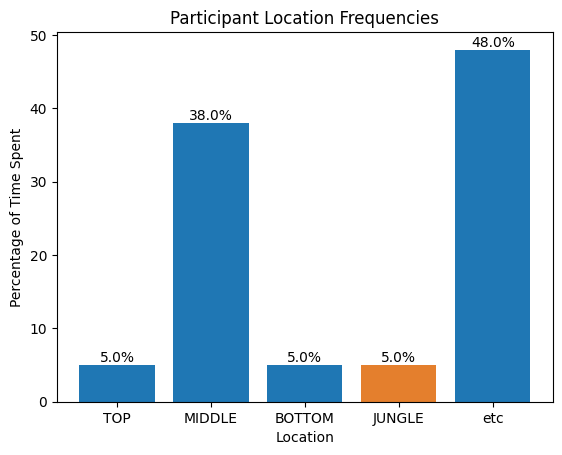

NameError: ignored

In [ ]:
def position_visualize(result):

    locations = ['TOP', 'MIDDLE', 'BOTTOM', 'JUNGLE', 'etc']
    values = [result[loc] for loc in range(1, 6)]

    # 해당 유저의 teamposition
    my_position = match_info[match_info['puuid'] == puuid]['teamPosition'].iloc[0]

    if my_position == 'UTILITY':
        my_position = 'BOTTOM' # (UTILTY 인 경우도 BOTTOM 라인)

    max_idx = np.argmax(values)  # 가장 큰 값의 인덱스
    idx = locations.index(my_position)

    # 그래프 생성
    fig, ax = plt.subplots()
    ax.bar(locations, values)

    # 그래프 타이틀, x축 라벨, y축 라벨 설정
    ax.set_title('Participant Location Frequencies')
    ax.set_xlabel('Location')
    ax.set_ylabel('Percentage of Time Spent')

    # 백분율 값을 막대 그래프 위에 표시
    for i, val in enumerate(values):
        ax.text(i, val, f'{val:.1f}%', ha='center', va='bottom')

    ax.bar(locations[idx], values[idx], color='#E47F2D') # 해당 유저 포지션의 막대그래프

    # 그래프 표시
    plt.show()

    most_spent_line = locations[max_idx]
    if my_position == 'TOP':
        my_time = TOP
    elif my_position == 'MIDDLE':
        my_time = MIDDLE
    elif my_position in ['BOTTOM', 'UTILITY']:
        my_time = BOTTOM
    elif my_position == 'JUNGLE':
        my_time = JUNGLE
    else:
        my_time = etc

    print(f"'{first_match_id}' 경기 {summoner_name} 소환사의 포지션 : {summoner_position} ")
    print(f"{my_position} 라인에서 머문 비율 : {my_time}% ")
    print(f"{my_position}을 제외한 나머지 라인(귀환포함) : {100 - my_time}% ")
    print(f" 라인전 (15분 기준) 동안 가장 많이 머물렀던 라인 : {most_spent_line}")
position_visualize(result)

# kill, death log


In [ ]:
# moving
moving

In [ ]:
# kill/ death
df

In [ ]:
# kill /death/ moving data , union

moving_self = moving[moving['participantId'] == summoner_participantId]
moving_self = moving_self[['participantId','position','timestamp']]
moving_self

In [ ]:
participant_ids = []
kill_logs = []
death_logs = []

for i in range(len(match_data_log)):
    try:
        # Get participant id
        id_df = pd.DataFrame(match_data_log[i]['info']['participants'])
        participant_id = id_df[id_df['puuid'] == puuid]['participantId'].values[0]
        participant_ids.append(participant_id)

        # Get kill logs
        for frame in match_data_log[i]['info']['frames']:
            for event in frame['events']:
                if event['type'] == 'CHAMPION_KILL':
                    if event['killerId'] == participant_id:
                        event['matchId'] = match_data_log[i]['metadata']['matchId']
                        kill_logs.append(event)
                    elif event['victimId'] == participant_id:
                        event['matchId'] = match_data_log[i]['metadata']['matchId']
                        death_logs.append(event)
    except KeyError:
        print("KeyError occurred for match", i)

kill_logs_df = pd.DataFrame(kill_logs)[['matchId','timestamp','killerId','victimId','assistingParticipantIds','position']] if len(kill_logs) > 0 else None # kill 이나 death가 없는 경우 빈프레임으로 남긴다.
death_logs_df = pd.DataFrame(death_logs)[['matchId','timestamp','killerId','victimId','assistingParticipantIds','position']] if len(death_logs) > 0 else None

In [ ]:
kill = df[['killerId','position','timestamp']]
death = df[['victimId','position','timestamp']]

kill = df[['killerId','position','timestamp']]
kill['kill'] = 1
kill.rename(columns={'killerId':'participantId'}, inplace=True)
kill = kill.sort_values(by='participantId',ignore_index=True ,ascending=True)
kill['participantId'] = kill['participantId'].astype(int)

death = df[['victimId','position','timestamp']]
death['death'] = 1
death.rename(columns={'victimId':'participantId'}, inplace=True)
death = death.sort_values(by='participantId',ignore_index=True ,ascending=True)
death['participantId'] = death['participantId'].astype(int)

In [ ]:
df = pd.concat([kill, moving], axis=0, ignore_index=True, sort=False)
logs_df = pd.concat([death, df], axis=0, ignore_index=True, sort=False)
logs_df = logs_df.sort_values(by=['participantId', 'timestamp'], ignore_index=True, ascending=True)

In [ ]:
logs_df

In [ ]:
# merge 성공!

merged_df = pd.merge(death_logs_df, champion_info, left_on=['matchId', 'killerId'], right_on=['matchId', 'participantId'], how='left')
merged_df = pd.merge(merged_df, champion_info, left_on=['matchId', 'victimId'], right_on=['matchId', 'participantId'], suffixes=('_killer', '_victim'), how='left')

# Convert float values in 'assistingParticipantIds' column to empty lists
merged_df['assistingParticipantIds'] = merged_df['assistingParticipantIds'].apply(lambda x: [] if isinstance(x, float) else x)

# Iterate over each row in the merged dataframe
for i, row in merged_df.iterrows():
    # Get the IDs of the assisting players
    assisting_ids = row['assistingParticipantIds']

    # Get the positions of the assisting players
    assisting_positions = [champion_info.loc[(champion_info['matchId']==row['matchId']) & (champion_info['participantId']==id), 'teamPosition'].values[0] for id in assisting_ids]

    # Combine the positions and store the result in a new column
    merged_df.at[i, 'assisting_positions'] = ','.join(assisting_positions)

death_logs_position = merged_df[['matchId','timestamp', 'killerId','victimId', 'assistingParticipantIds', 'teamPosition_killer','teamPosition_victim','assisting_positions','position']]
death_logs_position

,matchId,timestamp,killerId,victimId,assistingParticipantIds,teamPosition_killer,teamPosition_victim,assisting_positions,position
0,KR_6430660256,706604,2,7,"[3, 4]",JUNGLE,JUNGLE,"MIDDLE,BOTTOM","{'x': 13201, 'y': 2848}"
1,KR_6430660256,1637996,4,7,"[1, 3]",BOTTOM,JUNGLE,"TOP,MIDDLE","{'x': 5690, 'y': 8920}"
2,KR_6430660256,1770961,2,7,"[1, 4, 5]",JUNGLE,JUNGLE,"TOP,BOTTOM,UTILITY","{'x': 5070, 'y': 9666}"
3,KR_6430660256,1949922,4,7,"[1, 2, 3, 5]",BOTTOM,JUNGLE,"TOP,JUNGLE,MIDDLE,UTILITY","{'x': 11846, 'y': 7299}"
4,KR_6430660256,2058593,4,7,"[1, 3, 5]",BOTTOM,JUNGLE,"TOP,MIDDLE,UTILITY","{'x': 10090, 'y': 5977}"


# ① 기존 알고리즘을 벗어난 리폿 행동

- 자기 라인 안가고 팀원들 따라다님 스킬로방해함 ☞  **`이동경로`**확인 + 팀원들을 방해하는데 시간을 하루종일 썼다면 , **`팀기여도`** (딜량,타워딜량,시야점수)가 현저히 낮을것,

- 신고당한 유저의 팀포지션을 확인한뒤, 각 포지션에 맞는 역할을 충분히 이행 했는지 확인하자. 그렇다면 본인이 고른 포지션의 역할을 잘 했는지 판별할 기여도(?) 변수들이 필요하다.

## 팀기여도판별
- UTILITY :  시야점수(★★) , 어시스트(중요도★), 갱성공 + 그외 챔피언에 따라 다르긴한테 보통 힐량이나 CC기 ?
- BOTTOM : CS, 딜량(타워포함), KDA, (★★)
- MID,TOP : CS, 딜량, KDA, 갱킹
- JUNGLE : 정글 오브젝트CS(★★★), 갱킹(★)
- 공통변수 : kda, 타워와 관련된 변수 등..
## 예시
신고된 summoner_name -> match_data['teamposition'] 확인 -> 만약에 UTILITY 인경우 이동좌표 로그가 바텀 위주로 남아있는지 확인(최소 10분간 라인전은 해당 포지션 위치에 있는 경우가 대부분이다. 하지만 유저가 다양하듯 그렇지 않는 경우도 있다. 서폿이 미드나 탑에 2렙 갱킹을 가는 경우도 많다. 하지만 이런 case에는 , 갱킹 성공시 -> kill,assist가 지표가 될것이고. 정말 갱을 목적으로 간 유저라면 하루종일 그 라인에 머물지는 않을 것 이다. 하지만 사실 여전히 애매하긴 하다. ) ->   UTILITY 기여도 변수 계산


# ② 알고리즘이 명확한 리폿 행동
- 게임 나감 or 우물잠수 ☞ timstamp , etc
- 미드 달려(타워돌진) ☞ 타워에게 받은 피해량, death_log
- 욕설 (은 현재 제공된 api 데이터로 불가능)

>  ✔ 그래서 결국 **리폿을 할지 안할지 최종 점수**를 계산해야 하는데 어떻게 점수를 매겨야 할까...?


### ① 신고된 유저의 랭크의 평균 수치를 기준으로 한다.

랭크별로 평균 수치가 있을 것 이다. 예를들어 실버티어의 JUNGLE 평균 정글 CS, 평균 KDA, 등등/ 리폿 범위에 들어가는 적당한 구간을 나눠야한다. 그래프를 보면서? 물론 그냥 실력이 낮아서 하위 범위에 들어갈 수 있기 때문에 무조건적으로 보면 안된다. 뭐 어쩔 수 없다. 그러면 일단 RANK 별로 모든 평균 수치를 구해야겠네 ㄷㄷ

### ② 해당 경기를 기준으로 한다.
신고가 들어온 경기가 가장 최근경기라고하자. 위에서 정한 포지션비교, 팀원비교, 전체비교를 통해서 점수를 매긴다. 사실 RIOT의 공식 리폿 시스템을 보면 해당경기 뿐만 아니라 최소 전에 일어났던 경기 10개를 본다고 알려져 있기 때문에 그 전경기들도 참고해야 한다. 그래서 점수를 어떻게 매기냐 \

- 이동경로 점수(moving) \
10분동안 해당라인에 머물지 않은경우, 일단 의심해 볼수 있다.
- position 점수 \


In [ ]:
# match_info 에서 timeplayed 는 second 단위, 1655 = 27분 35초
# 'moreEnemyJungleThanOpponent' 의 값이 낮다는것은! 상대 정글러보다 카정을 많이 갔다는 것, 상대 포지션과 비교를 하기 때문에 상대방과 나 모두 반대편의 정글에 가지 않았다면 ' 0 '
# 'pickKillWithAlly ' 해당 참가자가 자신의 아군 챔피언과 함께 상대방 챔피언을 처치한 횟수를 나타내는 지표
# 'alliedJungleMonsterKills' 아군 정글에서 처치한 (미니언이 아닌) 정글 몬스터 수
# 'skillshotsHIT' 의 경우 논타겟 스킬만 측정이 된다. 이즈리얼 Q 를 맞췄을 경우 측정이 되지만.  애니의 Q (타겟팅) 스킬은 측정이 되지 않음. 타겟팅 적중률로 봐야 할듯??
# cs의 경우 정글 cs 와 미니언 cs 랑 나눠져있기 때문에 총 cs는 합쳐야한다.

In [ ]:
match_info

,teamId,puuid,summonerName,participantId,teamPosition,challenges,championName,lane,kills,deaths,assists,totalMinionsKilled,neutralMinionsKilled,goldEarned,goldSpent,champExperience,item0,item1,item2,item3,item4,item5,item6,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,damageDealtToTurrets,damageDealtToBuildings,totalTimeSpentDead,visionScore,win,timePlayed,soloKills,abilityUses,damageTakenOnTeamPercentage,skillshotsDodged,skillshotsHit,laneMinionsFirst10Minutes,controlWardsPlaced,visionScoreAdvantageLaneOpponent,visionScorePerMinute,wardTakedowns,effectiveHealAndShielding,dragonTakedowns,baronTakedowns,teamBaronKills,alliedJungleMonsterKills,enemyJungleMonsterKills,epicMonsterKillsNearEnemyJungler,getTakedownsInAllLanesEarlyJungleAsLaner,jungleCsBefore10Minutes,junglerTakedownsNearDamagedEpicMonster,kda,killsOnOtherLanesEarlyJungleAsLaner,moreEnemyJungleThanOpponent,takedownsBeforeJungleMinionSpawn,junglerKillsEarlyJungle,killsOnLanersEarlyJungleAsJungler,matchId
0,100,4kHdUD557MQjzWksmwfgX1fCSxWmKKtT2454OtOohW2HBG...,기피수,1,TOP,"{'12AssistStreakCount': 0, 'abilityUses': 225,...",Yone,TOP,3,6,0,92,2,5942,5900,7615,1055,6673,3006,1053,0,0,3340,79231,12584,13639,1712,1712,137,11,False,1223,3,225,0.243385,14,12,44,0,0.349606,0.563641,1,0.000000,0,0,0,5,0,0,0.0,0.0,0,0.500000,0.0,0.0,0,NaN,NaN,KR_6435072106
1,100,m4TNbdabkUfFjtpndt93Rc12-4IN9CVIw9u-tR6Z7-EFy7...,O0OO0OO0O00,2,JUNGLE,"{'12AssistStreakCount': 0, 'abilityUses': 42, ...",Nunu,TOP,0,3,0,47,4,3824,3150,4112,3117,1102,3070,3802,0,0,3340,30542,53,3707,97,97,34,1,False,1223,0,42,0.066155,7,3,25,0,-0.913907,0.064825,0,0.000000,0,0,0,1,0,0,NaN,4.0,0,0.000000,NaN,-28.0,0,0.0,0.0,KR_6435072106
2,100,bFopk58d4TBkPJHfSPUCXQG0oTMEO3fqi-U-0HO6DIH2Ha...,qpwlem,3,MIDDLE,"{'12AssistStreakCount': 0, 'abilityUses': 154,...",Sylas,MIDDLE,1,3,0,68,0,4607,3975,6174,1056,0,6656,1001,0,2031,3340,30005,4302,13697,499,499,72,6,False,1223,0,154,0.244414,5,6,36,1,-0.442820,0.338986,0,0.000000,0,0,0,0,0,0,0.0,0.0,0,0.333333,0.0,0.0,0,NaN,NaN,KR_6435072106
3,100,xH-gol-URTiBDBi-H83n803vaXSgA4vzS4_oHwGVSZ_OD5...,왕왕이밥그릇,4,BOTTOM,"{'12AssistStreakCount': 0, 'abilityUses': 78, ...",Samira,BOTTOM,4,4,2,80,0,7152,6100,5042,1055,6673,3134,3006,0,0,3340,37581,7089,11851,90,90,88,6,False,1223,2,78,0.211483,2,17,47,0,-0.569680,0.315916,1,90.000000,0,0,0,0,0,0,0.0,0.0,0,1.500000,0.0,0.0,0,NaN,NaN,KR_6435072106
4,100,JcW2S34zQdpeKarUicrTjf3MAcSS3_9R0xJagBQPKCjLQ3...,배이징 두,5,UTILITY,"{'12AssistStreakCount': 0, 'abilityUses': 65, ...",Pyke,BOTTOM,3,5,3,14,0,4912,4600,5491,3855,6691,1036,1036,1001,0,3340,12458,4047,13145,0,0,81,6,False,1223,1,65,0.234564,11,12,11,0,-0.821022,0.338880,0,0.000000,0,0,0,0,0,0,0.0,0.0,0,1.200000,0.0,0.0,0,NaN,NaN,KR_6435072106
5,200,m1gN65PnnS77u3jKSK7nUp5P5XVgOvHkci0gmUpZJZkB_K...,부엉이맛탕,6,BOTTOM,"{'12AssistStreakCount': 0, 'abilityUses': 180,...",Singed,BOTTOM,5,3,4,109,4,7885,7535,7474,1052,1026,1056,3047,4633,1011,3340,65553,8298,11277,3344,3344,68,14,True,1223,0,180,0.225916,10,0,52,2,1.323854,0.734142,0,0.000000,1,0,0,0,0,0,0.0,0.0,0,3.000000,0.0,0.0,0,NaN,NaN,KR_6435072106
6,200,ISKGkz7a2nzLRas227jLBo_ax6mTYrm3crYEA7GCRrvJyU...,또또다른그림자,7,JUNGLE,"{'12AssistStreakCount': 0, 'abilityUses': 171,...",Ekko,JUNGLE,3,1,1,16,112,9088,8385,8696,3152,2031,0,1052,4629,3020,3340,127383,3033,14474,4058,4058,16,15,True,1223,1,171,0.289945,1,12,1,0,10.615329,0.752962,0,0.000000,3,0,0,24,6,0,NaN,44.0,0,4.000000,NaN,0.0,0,0.0,1.0,KR_6435072106
7,200,32DthJoOr6Rsna4XpvZI4abcjvi_NH85VwSx-M3sOqie0S...,김태양에미련없다,8,MIDDLE,"{'12AssistStreakCount': 0, 'abilityUses': 165,...",Xerath,MIDDLE,7,0,2,139,2,9781,9100,9200,1056,3020,6655,3041,4645,0,3363,78829,17925,6657,4524,4524,0,12,True,1223,3,165,0.133353,4,34,70,0,0.794751,0.608396,1,0.000000,0,0,0,0,1,0,0.0,0.0,0,9.000000,0.0,0.0,0,NaN,NaN,KR_6435072106
8,200,TFQ__N5H0JE8rZwJGTxGICHXlA12VcBA4-m7ja7x-NxVb2...,양꼬치야,9,TOP,"{'12AssistStreakCount': 0, 'abilityUses': 137,...",Jinx,TOP,3,4,4,96,16,7740,6800,8654,2033,1055,3006,6672,1038,0,3340,

In [ ]:
chall = match_info['challenges'].tolist()
chall_df = pd.DataFrame(chall)
chall_df

,12AssistStreakCount,abilityUses,acesBefore15Minutes,alliedJungleMonsterKills,baronTakedowns,blastConeOppositeOpponentCount,bountyGold,buffsStolen,completeSupportQuestInTime,controlWardsPlaced,damagePerMinute,damageTakenOnTeamPercentage,dancedWithRiftHerald,deathsByEnemyChamps,dodgeSkillShotsSmallWindow,doubleAces,dragonTakedowns,earlyLaningPhaseGoldExpAdvantage,effectiveHealAndShielding,elderDragonKillsWithOpposingSoul,elderDragonMultikills,enemyChampionImmobilizations,enemyJungleMonsterKills,epicMonsterKillsNearEnemyJungler,epicMonsterKillsWithin30SecondsOfSpawn,epicMonsterSteals,epicMonsterStolenWithoutSmite,flawlessAces,fullTeamTakedown,gameLength,getTakedownsInAllLanesEarlyJungleAsLaner,goldPerMinute,hadOpenNexus,immobilizeAndKillWithAlly,initialBuffCount,initialCrabCount,jungleCsBefore10Minutes,junglerTakedownsNearDamagedEpicMonster,kTurretsDestroyedBeforePlatesFall,kda,killAfterHiddenWithAlly,killParticipation,killedChampTookFullTeamDamageSurvived,killsNearEnemyTurret,killsOnOtherLanesEarlyJungleAsLaner,killsOnRecentlyHealedByAramPack,killsUnderOwnTurret,killsWithHelpFromEpicMonster,knockEnemyIntoTeamAndKill,landSkillShotsEarlyGame,laneMinionsFirst10Minutes,laningPhaseGoldExpAdvantage,legendaryCount,lostAnInhibitor,maxCsAdvantageOnLaneOpponent,maxKillDeficit,maxLevelLeadLaneOpponent,moreEnemyJungleThanOpponent,multiKillOneSpell,multiTurretRiftHeraldCount,multikills,multikillsAfterAggressiveFlash,outerTurretExecutesBefore10Minutes,outnumberedKills,outnumberedNexusKill,perfectDragonSoulsTaken,perfectGame,pickKillWithAlly,playedChampSelectPosition,poroExplosions,quickCleanse,quickFirstTurret,quickSoloKills,riftHeraldTakedowns,saveAllyFromDeath,scuttleCrabKills,skillshotsDodged,skillshotsHit,snowballsHit,soloBaronKills,soloKills,stealthWardsPlaced,survivedSingleDigitHpCount,survivedThreeImmobilizesInFight,takedownOnFirstTurret,takedowns,takedownsAfterGainingLevelAdvantage,takedownsBeforeJungleMinionSpawn,takedownsFirstXMinutes,takedownsInAlcove,takedownsInEnemyFountain,teamBaronKills,teamDamagePercentage,teamElderDragonKills,teamRiftHeraldKills,threeWardsOneSweeperCount,tookLargeDamageSurvived,turretPlatesTaken,turretTakedowns,turretsTakenWithRiftHerald,twentyMinionsIn3SecondsCount,unseenRecalls,visionScoreAdvantageLaneOpponent,visionScorePerMinute,wardTakedowns,wardTakedownsBefore20M,wardsGuarded,junglerKillsEarlyJungle,killsOnLanersEarlyJungleAsJungler,mythicItemUsed,controlWardTimeCoverageInRiverOrEnemyHalf,earliestDragonTakedown,firstTurretKilledTime,killingSprees,highestChampionDamage,highestCrowdControlScore,mejaisFullStackInTime,soloTurretsLategame,fasterSupportQuestCompletion,highestWardKills
0,0,225,0,5,0,0,0,0,0,0,616.922264,0.243385,0,6,2,0,0,0,0.000000,0,0,30,0,0,0,0,0,0,0,1223.946306,0.0,291.292362,0,0,0,0,0.0,0,0,0.500000,0,0.272727,0,3,0.0,0,0,0,0,4,44,0,0,0,19.0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,14,12,0,0,3,6,0,0,0,3,0,0,3,0,0,0,0.448198,0,0,0,0,2,0,0,3,0,0.349606,0.563641,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,42,0,1,0,0,0,0,0,0,2.638540,0.066155,0,3,0,0,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,1223.946306,NaN,187.464278,0,0,1,0,4.0,0,0,0.000000,0,0.000000,0,0,NaN,0,0,0,0,0,25,0,0,0,4.0,0,1,-28.0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,7,3,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0.001917,0,0,0,0,2,0,0,2,0,-0.913907,0.064825,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,154,0,0,0,0,150,0,0,1,210.926863,0.244414,0,3,0,0,0,0,0.000000,0,0,12,0,0,0,0,0,0,0,1223.946306,0.0,225.872826,0,1,0,0,0.0,0,0,0.333333,0,0.090909,0,0,0.0,0,1,0,0,4,36,0,0,0,3.0,0,0,0.0,0,0,0,0,0,1,0,0,0,1,1.0,0,0,0,0,0,0,0,5,6,0,0,0,5,0,0,0,1,0,0,0,0,0,0,0.153240,0,0,0,0,0,0,0,2,0,-0.442820,0.338986,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,78,0,0,0,0,600,0,0,0,347.556846,0.211483,0,3,0,0,0,0,90.000000,0,0,6,0,0,0,0,0,0,0,1223.946306,0.0,350.642560,0,1,0,0,0.0,0,0,1.500000,0,0.545455,0,1,0.0,0,0,0,0,9,47,0,0,0,5.0,0,1,0.0,0,0,1,0,0,1,0,0,0,4,1.0,0,0,0,0,0,0,0,2,17,0,0,2,3,0,2,0,6,1,0,6,1,0,0,0

# ..

신고 매뉴얼



신고된 유저의 {rank} {position} \
common_var + {position}_var \

[ 포지션 평가 ] \
랭크 : 아이언 \
포지션 : 정글 \
기본적으로 봐야할변수:  \
kda, 딜량, 받은피해량,

< 아이언 정글 평균 vs 신고된 유저 > \
< 상대 포지션 vs 본인 포지션 > \

< 팀원내 비교 >


In [ ]:
# ------------------------------------------------------- 상대 position 비교 ----------------------------------------------------- #
# 변수정리
common_var = match_info[['timePlayed','puuid','teamId'	,'summonerName',	'participantId','teamPosition','championName','kills','deaths','assists','kda','soloKills',
                         'laneMinionsFirst10Minutes','totalMinionsKilled','neutralMinionsKilled','totalTimeSpentDead']]
skill_var = match_info[['skillshotsDodged','skillshotsHit','enemyChampionImmobilizations']]
dealt_var = match_info[['totalDamageDealt','totalDamageDealtToChampions','totalDamageTaken','damageDealtToBuildings']] # 알고리즘이 명확한(?) 변수
UTILITY_var = match_info[['visionScore','controlWardsPlaced','visionScoreAdvantageLaneOpponent','wardTakedowns','effectiveHealAndShielding']]
JUNGLE_var = match_info[['jungleCsBefore10Minutes','alliedJungleMonsterKills','enemyJungleMonsterKills','moreEnemyJungleThanOpponent']]



# 상대포지션

# summoner_position # 검색한 유저의 puuid에 해당하는 포지션
#                   # 같은 포지션을 갖고 있는 상대방 데이터 가져오기
# compare_position = match_info[(match_info['teamPosition'] == summoner_position)]  #& (match_info['puuid'] != puuid)


# ------------------------------------------------------- 포지션 기여도 측정 ----------------------------------------------------- #


if summoner_position == 'UTILITY':
    compare_position_df = common_var.join([UTILITY_var, dealt_var])
elif summoner_position == 'JUNGLE':
    compare_position_df = common_var.join([JUNGLE_var, dealt_var])
elif summoner_position in ['TOP', 'MIDDLE', 'BOTTOM']:
    compare_position_df = common_var.join(dealt_var)
else:
  print(f'test')

compare_position = compare_position_df[(compare_position_df['teamPosition'] == summoner_position)]


# ------------------------------------------------------- 전체 비교 (?) --------------------------------------------------------- #
compare_position

In [ ]:
# plot dash

!pip install jupyter-dash
!jupyter serverextension enable --py jupyter_dash
!pip install dash
!pip install dash-renderer
!pip install dash-html-components
!pip install dash-core-components



In [ ]:
!pip install plotly


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import plotly.graph_objs as go
import plotly.offline as pyo

In [ ]:
participant_Id = id_df.loc[id_df['puuid'] == puuid, 'participantId'].iloc[0]  # 소환사 particiapntId
participant_champs = champion_info[champion_info['participantId'] == participant_id] # 소환사 champion

## 시각화 연습

In [ ]:
# visionScore	controlWardsPlaced
    # if summoner_name in data['summonerName'].values:
    #     trace.marker.color = ['#b5b4b4' if x == summoner_name else '#2f68ee' for x in data['summonerName']]

fig1 = go.Figure()
for teamid in [100, 200]:
    data = compare_position[compare_position['teamId']==teamid]
    if teamid == 100:
        name = f'Blue team {summoner_position}'
    elif teamid == 200:
        name = f'Red team {summoner_position}'
    trace = go.Bar(x=data['visionScore'], y=data['summonerName'], name=name, orientation='h',width=0.7)
    fig1.add_trace(trace)


fig1.update_layout(title='Deal by summonerName', xaxis_title='visionScore', yaxis_title='summonerName')


fig1.update_layout(
    {
      "title" : {
          "text": f"{summoner_position} 포지션 visionScore",
          "font": {
              "size": 25
          }
      },

      "xaxis": {
          "title": "visionScore",
          "tickmode": "auto",
          "dtick": 1
      },
      "yaxis": {
          "title": "summonerName",
          "tickmode": "linear",
          "dtick": 1
      },
      "template": "plotly_dark",
      "width" : 1200 ,
      "height" : 400
    }
)



## summoner_position 이 JUNGLE 인경우


In [ ]:
variables = ['jungleCsBefore10Minutes','enemyJungleMonsterKills']
for variable in variables:
    fig = go.Figure()
    for teamid in [100, 200]:
        data = compare_position[compare_position['teamId']==teamid] # compare_position
        if teamid == 100:
            name = f'Blue team {summoner_position}'
        elif teamid == 200:
            name = f'Red team {summoner_position}'

        trace = go.Bar(x=data[variable], y=data['summonerName'], name=name, orientation='h')
        # if summoner_name in data['summonerName'].values:
        #    trace.marker.color = ['#b5b4b4' if x == summoner_name else '#2f68ee' for x in data['summonerName']]
        fig.add_trace(trace)

    fig.update_layout(title=f"{summoner_position} 포지션 {variable}", xaxis_title=variable, yaxis_title='summonerName', width=1200, height=400, template='plotly_dark')
    fig.show()

## 각랭크별 summoner_id, puuid 가져오기

>  총 10000개 position_data  iron_rank , 해당 유저의 RANK 에 해당하는 MATCH_DATA 들을 가져와서, 신고가 들어왔을 때 해당 내용의 변수를 비교하기 위한 평균점수를 구해야한다.

In [ ]:
BRONZE_url = 'https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/BRONZE/{}?page={}&api_key={}'
SILVER_url = 'https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/SILVER/{}?page={}&api_key={}'
IRON_url = 'https://kr.api.riotgames.com/lol/league-exp/v4/entries/RANKED_SOLO_5x5/IRON/{}?page={}&api_key={}'

In [ ]:
divisions = ['I','II','III','IV']

IRON_tier = []
for division in divisions:
  for page_num in range(1,20):
      url_now = IRON_url.format(division,page_num,api_key)

      reqq = requests.get(url_now).text

      if reqq == '[]':
          break
      else:
          df = json.loads(reqq) # 함수는 JSON 형태의 문자열을 입력으로 받아들이고 Python의 딕셔너리 자료형으로 변환
          IRON_tier.append(pd.DataFrame(df))

IRON_df = pd.concat(IRON_tier)

In [ ]:
IRON_df

In [ ]:
IRON_df['total_games'] = IRON_df['wins'] + IRON_df['losses']

In [ ]:
# pd.set_option('display.max_rows',500)
summoner_names = IRON_df['summonerName'].tolist()

In [ ]:
summoner_names

In [ ]:
def get_match_data(summoner_names, api_key, start=0, count=1):
    match_data = []
    for summoner_name in summoner_names:
        # Get summoner puuid
        sohwan = "https://kr.api.riotgames.com/lol/summoner/v4/summoners/by-name/{}?api_key={}"
        url = sohwan.format(summoner_name, api_key)
        response = requests.get(url)
        puuid = response.json()['puuid']

        # Get match ids
        matchid_url = "https://asia.api.riotgames.com/lol/match/v5/matches/by-puuid/{}/ids?type=ranked&start={}&count={}&api_key={}"
        url = matchid_url.format(puuid, start, count, api_key)
        response = requests.get(url)
        match_ids = response.json()


        # Get match data
        url2 = 'https://asia.api.riotgames.com/lol/match/v5/matches/{}?api_key={}'  # matchid , api_key
        match_data2 = []
        for match_id in match_ids:
            url_now = url2.format(match_id, api_key)
            time = requests.get(url_now).text
            df = json.loads(time)

            match_data2.append(pd.DataFrame(df))

        match_df = pd.concat(match_data2) #

        df = pd.DataFrame(match_df['info']['participants'])
        sample = df[['teamId','puuid','summonerName','participantId','teamPosition', 'challenges',
                    'championName','lane','kills','deaths','assists','totalMinionsKilled','neutralMinionsKilled',
                    'totalDamageDealt','totalDamageDealtToChampions','totalDamageTaken','damageDealtToTurrets','damageDealtToBuildings',
                    'totalTimeSpentDead','visionScore','win','timePlayed']]

        challenge = pd.DataFrame(sample['challenges'].tolist())

        col = challenge[['soloKills','abilityUses','skillshotsDodged','skillshotsHit','laneMinionsFirst10Minutes','controlWardsPlaced',
                         'wardTakedowns','effectiveHealAndShielding']]
        jungle_col = challenge.filter(regex='^jungle|Jungle|kda')

        match_info = pd.concat([sample , col, jungle_col], axis = 1)
        match_info['matchId'] = match_df['metadata']['matchId']

        match_data.append(match_info)

    return match_data


summoner_names = ['아이언조련사','섭섭한틀니']
match_data = get_match_data(summoner_names, api_key)

In [ ]:
t = pd.concat(match_data)
t

In [ ]:
import time

In [ ]:
summoner_names = summoner_names[:1000]
summoner_names

In [ ]:
def get_match_ids(summoner_names, api_key, start=0, count=5):
    match_ids = []
    for summoner_name in tqdm(summoner_names):
        # Get summoner puuid
        sohwan = "https://kr.api.riotgames.com/lol/summoner/v4/summoners/by-name/{}?api_key={}"
        url = sohwan.format(summoner_name, api_key)
        response = requests.get(url)
        try:
            puuid = response.json()['puuid']
        except KeyError:
            continue

        # Get match ids
        matchid_url = "https://asia.api.riotgames.com/lol/match/v5/matches/by-puuid/{}/ids?type=ranked&start={}&count={}&api_key={}"
        url = matchid_url.format(puuid, start, count, api_key)
        response = requests.get(url)
        if str(response)!='<Response [200]>':
            if str(response) =='<Response [429]>':
                time.sleep(120)
            else:
                time.sleep(10)
        else:
            match_ids += response.json()
    return match_ids

match_ids = get_match_ids(summoner_names, api_key)



100%|██████████| 1000/1000 [25:48<00:00,  1.55s/it]


In [ ]:
match_ids = list(set(match_ids)) # 5000
match_ids # 4746

In [ ]:
# text 파일 저장
with open('match_ids.txt', 'w') as f:
    for item in match_ids:
        f.write("%s\n" % item)

In [ ]:
# txt 파일 불러오는법
with open('/content/drive/MyDrive/match_ids.txt', 'r') as file:
    match_ids = file.read().split('\n')


match_ids

## 대략 4700 개의 match_id

In [ ]:
match_ids = match_ids[:100]
match_ids

In [ ]:
import time

In [ ]:
import time
def get_match_data(match_ids, api_key):
    match_data = []
    url_v5 = 'https://asia.api.riotgames.com/lol/match/v5/matches/{}?api_key={}'  # matchid , api_key

    for i, match_id in enumerate(tqdm(match_ids)):
        url_now = url_v5.format(match_id, api_key)
        response = requests.get(url_now)

        if response.status_code == 200:
            time_data = response.text
            df = json.loads(time_data)
            match_data.append(pd.DataFrame(df))
        elif response.status_code == 429:
            time.sleep(120)
        else:
            time.sleep(10)


    match_df = pd.concat(match_data)
    df = pd.DataFrame(match_df['info']['participants'])

    participants_list = []

    for i in range(len(df)):
        participant_df = pd.DataFrame(df.iloc[i]['info'])
        participant_df['match_id'] = match_df['metadata']['matchId'][i]
        participants_list.append(participant_df)


    match_data_10 = pd.concat(participants_list)

    positions = ['MIDDLE', 'TOP', 'JUNGLE', 'BOTTOM', 'UTILITY',''] # null 값인 경우 ''

    selected_columns = ['match_id','timePlayed','teamId','summonerName','participantId','puuid','teamPosition', 'challenges',
        'championName','lane','kills','deaths','assists','totalMinionsKilled','neutralMinionsKilled','goldEarned','goldSpent','champExperience','item0','item1','item2',
        'item3','item4','item5','item6','totalDamageDealt','totalDamageDealtToChampions','totalDamageTaken','damageDealtToTurrets','damageDealtToBuildings',
        'totalTimeSpentDead','visionScore','win','timePlayed'] # timeplayed second 단위, 1655 = 27분 35초

    position_data = {}
    for position in positions:
        position_data[position] = match_data_10[(match_data_10['teamPosition'] == position)][selected_columns] # (match_data_10['puuid'] == puuid) &  = 입력한 소환사의 정보만 뽑기

    position_data = pd.concat(position_data)

    return match_data_10, position_data
    # return match_df, df
match_data_10, position_data = get_match_data(match_ids, api_key)

100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


In [ ]:
position_data = position_data.reset_index(drop=True)
# position_data = position_data.dropna() # remove rows with null values


In [ ]:
df.to_csv('data.csv', encoding='utf-8')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/position_data.csv', encoding = 'cp949',index_col=0) #index_col 파일을 불러올때 인덱스를 지정
#  = pd.read_csv('/content/drive/MyDrive/position_data.csv', quotechar="'", encoding = 'cp949',index_col=0)


In [ ]:
df

In [ ]:
gold =df[['match_id','puuid','championName','kills','deaths','assists','summonerName','goldSpent','goldEarned']]

In [ ]:
gold['gold_dif'] = df['goldEarned']-df['goldSpent']

<ipython-input-6-88ed4c611d5f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold['gold_dif'] = df['goldEarned']-df['goldSpent']


In [ ]:
gold.describe()

,kills,deaths,assists,goldSpent,goldEarned,gold_dif
count,47000.000000,47000.000000,47000.000000,47000.000000,47000.000000,47000.000000
mean,5.963298,5.990532,7.159532,9801.853404,10585.663915,783.810511
std,5.070670,3.568823,5.548660,4195.094133,4275.294182,1087.210384
min,0.000000,0.000000,0.000000,0.000000,500.000000,-21766.000000
25%,2.000000,3.000000,3.000000,7025.000000,7747.000000,261.000000
50%,5.000000,6.000000,6.000000,9500.000000,10292.000000,645.000000
75%,8.000000,8.000000,10.000000,12250.000000,13198.000000,1238.000000
max,41.000000,29.000000,47.000000,53550.000000,32041.000000,12974.000000


In [ ]:
gold_min= gold[gold['gold_dif']  < -10000]

gold_min

NameError: ignored

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

sns.distplot(gold['gold_dif'])

## JSON 파일을 TO_CSV 하고 다시 불러 들여올때 주의 할점..
 API 로 불러들어온 파일은 CSV 로 저장하게 되면 JSON 형태가 아닌 문자열로 저장하게 된다. 그래서 'challenges' 컬럼의 경우 이중 dict 형태로 되어있기 때문에 에러가 발생한다.

✏  이 경우에는 JSON 데이터에서 문자열을 둘러싸는 큰따옴표(")가 작은따옴표(')로 바뀌어 있어서 생긴 문제일 가능성이 있음

따라서 challenges 컬럼의 값을 문자열에서 JSON 객체로 바꾸기 위해서는 다음과 같이 큰따옴표로 둘러싸인 문자열로 변환해주어야 한다.

In [ ]:
# challenges 컬럼의 값을 파이썬 객체로 변환
import json
df['challenges'] = df['challenges'].apply(lambda x: json.loads(x.replace("'", "\"")))


In [ ]:

challenge = pd.DataFrame(df['challenges'].tolist())
col = challenge[['soloKills','abilityUses','damageTakenOnTeamPercentage','skillshotsDodged','skillshotsHit','laneMinionsFirst10Minutes','controlWardsPlaced','visionScoreAdvantageLaneOpponent'
                , 'visionScorePerMinute','wardTakedowns','effectiveHealAndShielding','dragonTakedowns','baronTakedowns','teamBaronKills']]
jungle_col = challenge.filter(regex='^jungle|Jungle|kda')

iron_match = pd.concat([df , col, jungle_col], axis = 1)
# match_info['matchId'] = match_df['metadata']['matchId']

In [ ]:
iron_match.head()

In [ ]:
iron_match_t = iron_match [(iron_match['timePlayed'] >= 900) & (iron_match['timePlayed'] <= 2000)]

In [ ]:
# position 별 iron_match_t

UTIL_match = iron_match_t[iron_match_t['teamPosition'] == 'UTILITY']
MID_match = iron_match_t[iron_match_t['teamPosition'] == 'MIDDLE']
TOP_match = iron_match_t[iron_match_t['teamPosition'] == 'TOP']
JUNGLE_match = iron_match_t[iron_match_t['teamPosition'] == 'JUNGLE']
BOTTOM_match = iron_match_t[iron_match_t['teamPosition'] == 'BOTTOM']
MAIN_match = iron_match_t[iron_match_t['teamPosition'].isin(['MIDDLE','TOP','BOTTOM'])]
# UTIL_match.head()

In [ ]:
iron_match['timePlayed'].describe()

당연히 MATCH 마다 경기 시간이 다르고, 시간이 길수록 모든 수치가 높을것이다. 그렇다면 Timeplayed 기준을 어떻게 잡아야할까..  신고된 경기의 timeplayed 가 길다면 다르게 봐야함.. \
- iron 랭크의 평균 게임 시간은 1500 ~ 2000  (25분~33분) 28분
- visionScore : 45.535724
- wardTakedowns : 4.2

평균 수치들을 구했음. 이제 이걸 신고를 받은 경기와 match 해서 점수를 매겨야한다.


In [ ]:
# UTIL_time_28 = UTIL_match[(UTIL_match['timePlayed'] >= 900) & (UTIL_match['timePlayed'] <= 2200)]

In [ ]:
# ward_max = UTIL_time_28[UTIL_time_28['controlWardsPlaced'] == 61]
# ward_max

In [ ]:
fig, ax = plt.subplots(nrows=4, figsize=(8,8))

sns.histplot(UTIL_match['controlWardsPlaced'], ax=ax[0])
sns.histplot(UTIL_match['abilityUses'], ax=ax[1])
sns.histplot(UTIL_match['visionScore'], ax=ax[2])
sns.histplot(UTIL_match['visionScore'], ax=ax[3])

plt.tight_layout()
plt.show()

## vision score 는 utility가 가장 높을까?
약 9400개의 position 별 평균 visionscore을 보았을 때 utility의 visioscore 가 44로 가장 높았음. 그 다음 정글 21 나머지 position들은 . 16~17 사이로 비슷했다. 하위랭크에서도 utility의 시야점수가 높은걸로 봐서, utility에게 시야점수는 해당경기에 얼마나 기여했는지에 대한 큰 지표역할을 한다. ☞ 그렇다면 시야점수가 극도로 낮은경우 utility의 역할에 큰 기여를 했다고 보긴 어렵다고 볼 수있다.(그렇다고 극단적으로 판단하면 절대 안됨)

### 제어와드를 박는 횟수 또한 utility, jungle 순서대로 높았다.
MID 0.84 \
TOP 0.58 \
BOTTOM 0.57 \
utility 1.9 \
jungle 1.8 \

In [ ]:
# MID_match.describe() #17
# TOP_match.describe() #15
# MID_match.describe() #17
# JUNGLE_match.describe() #21
# BOTTOM_match.describe() #16
# UTIL_match['controlWardsPlaced'].describe() # 44
print(MID_match['controlWardsPlaced'].mean())
print(TOP_match['controlWardsPlaced'].mean())
print(JUNGLE_match['controlWardsPlaced'].mean())
print(BOTTOM_match['controlWardsPlaced'].mean())
print(UTIL_match['controlWardsPlaced'].mean())

0.841648590021692
0.5824295010845987
1.186396033467617
0.5704323570432357
1.887029288702929


## 평균차트 + 해당경기차트
해당랭크의 평균값 구하기



In [ ]:
print(JUNGLE_match['jungleCsBefore10Minutes'].quantile(0.05)) # 하위 0.05
JUNGLE_describe = pd.DataFrame(JUNGLE_match['jungleCsBefore10Minutes'].describe())
JUNGLE_describe

In [ ]:
# 점수 매기기 기준 하위 5% 인경우 -1
summoner_jungle_cs_10 = compare_position.loc[compare_position['summonerName'] == summoner_name, 'jungleCsBefore10Minutes'].values[0]
percentile_5 = JUNGLE_match['jungleCsBefore10Minutes'].quantile(0.05)
percentile = (JUNGLE_match['jungleCsBefore10Minutes'] < summoner_jungle_cs_10).mean() * 100

if summoner_jungle_cs_10 < percentile_5:
    print(f"'{first_match_id}'경기에서 {summoner_name} 유저의 jungleCsBefore10Minutes 값은 '{summoner_jungle_cs_10}' 이며 하위 5% 이하입니다.")
else:
    print(f"{summoner_name} 유저의 jungleCsBefore10Minutes 값은 상위 {100 - percentile:.2f}% 입니다.")


'KR_6444203749'경기에서 O0OO0OO0O00 유저의 jungleCsBefore10Minutes 값은 '0.0' 이며 하위 5% 이하입니다.


In [ ]:
# 평균값이 있으면 좋을거같은 변수들 .. 각 position match에서 평균값 구하기

jungle_cs10_mean = np.mean(JUNGLE_match['jungleCsBefore10Minutes'])
cs10_mean = np.mean(MAIN_match['laneMinionsFirst10Minutes'])
utility_vision_mean = np.mean(UTIL_match['visionScore'])
utility_wards_mean = np.mean(UTIL_match['controlWardsPlaced'])

print(cs10_mean)

55.62145550333144


In [ ]:
# JUNGLE . 10분동안 먹은 JUNGLE CS

variables = ['jungleCsBefore10Minutes']
for variable in variables:
    fig = go.Figure()
    for summoner in compare_position['summonerName'].unique():
        data = compare_position[compare_position['summonerName']==summoner]
        name = f'{summoner}'
        color = '#2a6af5' if data['teamId'].iloc[0] == 100 else '#f23d3d'
        trace = go.Bar(x=data[variable], y=[name], name=name, orientation='h', textposition='auto', marker=dict(color=color))
        fig.add_trace(trace)

    avg_trace = go.Bar(x=[jungle_cs10_mean], y=[f"IRON 랭크 평균"], name="평균 정글CS(10분)", orientation='h', marker=dict(color='#bbc0c7'))
    fig.add_trace(avg_trace)

    fig.update_layout(title=f"{summoner_position} Position {variable}", xaxis_title = variable, yaxis_title='summonerName', width=1200, height=400, template='plotly_dark')
    fig.show()


summoner_jungle_cs_10 = compare_position.loc[compare_position['summonerName'] == summoner_name, 'jungleCsBefore10Minutes'].values[0]
percentile_5 = JUNGLE_match['jungleCsBefore10Minutes'].quantile(0.05)
percentile = (JUNGLE_match['jungleCsBefore10Minutes'] < summoner_jungle_cs_10).mean() * 100

if summoner_jungle_cs_10 < percentile_5:
    print(f"'{first_match_id}'경기에서 {summoner_name} 유저의 10분동안 처치한 JungleCS 값은 '{summoner_jungle_cs_10}' 이며 하위 5% 이하입니다.")
else:
    print(f"{summoner_name} 유저의 jungleCsBefore10Minutes 값은 상위 {100 - percentile:.2f}% 입니다.") # 'KR_6444203749'


In [ ]:
# 피해량 부분은 해당경기 평균을 구하는게 맞다.

variables = ['totalDamageDealt','totalDamageDealtToChampions','totalDamageTaken']
for variable in variables:
    fig = go.Figure()
    for summoner in match_info['summonerName'].unique():
        data = match_info[match_info['summonerName']==summoner]
        name = f'{summoner}'
        color = '#2a6af5' if data['teamId'].iloc[0] == 100 else ('#d4d0cd' if summoner == summoner_name else '#f25050')  # 팀별로 red,blue, 해당유저는 회색
        trace = go.Bar(x=data[variable], y=[name], name=name, orientation='h', textposition='auto', marker=dict(color=color))
        fig.add_trace(trace)

    avg_trace = go.Bar(x=[jungle_cs10_mean], y=[f"IRON 랭크 평균"], name="평균 정글CS(10분)", orientation='h', marker=dict(color='#bbc0c7'))
    fig.add_trace(avg_trace)

    fig.update_layout(title=f" {variable}",
                      xaxis_title = variable,
                      yaxis_title='summonerName',
                      width=1200, height=400,
                      showlegend=False,
                      template='plotly_dark')
    fig.show()

In [ ]:
# main position CS 부분 (MID, TOP, BOTTOM에게 중요한 지표)
#
variables = ['laneMinionsFirst10Minutes']
for variable in variables:
    fig = go.Figure()
    for summoner in match_info['summonerName'].unique():
        data = match_info[match_info['summonerName']==summoner]
        name = f'{summoner}'
        color = '#2a6af5' if data['teamId'].iloc[0] == 100 else ('#d4d0cd' if summoner == summoner_name else '#f25050')  # 팀별로 red,blue, 해당유저는 회색
        trace = go.Bar(x=data[variable], y=[name], name=name, orientation='h', textposition='auto', marker=dict(color=color))
        fig.add_trace(trace)

    avg_trace = go.Bar(x=[cs10_mean], y=[f"IRON 랭크 평균"], name="10분 평균 CS(TOP,MID,BOTTOM)", orientation='h', marker=dict(color='#bbc0c7'))
    fig.add_trace(avg_trace)

    fig.update_layout(title=f" {variable}",
                      xaxis_title = variable,
                      yaxis_title='summonerName',
                      width=1200, height=400,
                      showlegend=False,
                      template='plotly_dark')


    fig.show()

In [ ]:
# 역시 주라인들은 10분간 CS 먹는 양이 크게 다르지는 않음.주요메인 라인 TOP.MID,BOTTOM 모두 비슷했다.
# 포지션 특성상 utility 와 jungle 만 차이가 있음.

fig, ax = plt.subplots(nrows=4, figsize=(8,8))

sns.kdeplot(MID_match['controlWardsPlaced'], ax=ax[0])
sns.kdeplot(MID_match['laneMinionsFirst10Minutes'], ax=ax[1])
sns.kdeplot(TOP_match['laneMinionsFirst10Minutes'], ax=ax[2])
sns.kdeplot(BOTTOM_match['laneMinionsFirst10Minutes'], ax=ax[3])

plt.tight_layout()
plt.show()


In [ ]:
# 각 포지션별로 가중치를 해당 변수에 대해서 어떻게 부여할지

var = ['totalDamageDealtToChampions','damageDealtToObjectives','totalCS','soloKils','kills','assists','visionScore','enemyChampionimmobilizations','damageSelfMitigated','totalDamageShiledOnTeammates','totalHealsOnTeammates']

# 역코딩이 필요한 변수
var = ['totalDamageTaken','death','totalTimeSpentDead']